In [40]:
import sys
sys.path.append('../..')
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import ta
import numpy as np
import datetime
from IPython.display import clear_output
from utilities.data_manager import ExchangeDataManager
from utilities.custom_indicators import get_n_columns
from utilities.bt_analysis import get_metrics, backtest_analysis
from utilities.plot_analysis import plot_equity_vs_asset, plot_futur_simulations, plot_bar_by_month
import nest_asyncio
nest_asyncio.apply()

In [41]:
class Strategy:
    def __init__(
        self,
        df_list,
        oldest_pair,
        type=["long"],
        params={},
    ):
        self.df_list = df_list
        self.oldest_pair = oldest_pair
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        self.params = params

    def populate_indicators(self):
        for pair in self.df_list:
            params = self.params[pair]
            df = self.df_list[pair]
            df.drop(
                columns=df.columns.difference(
                    ["open", "high", "low", "close", "volume"]
                ),
                inplace=True,
            )

            # -- Populate indicators --
            if params["src"] == "close":
                src = df["close"]
            elif params["src"] == "ohlc4":
                src = (df["close"] + df["high"] + df["low"] + df["open"]) / 4

            df["ma_base"] = ta.trend.sma_indicator(
                close=src, window=params["ma_base_window"]
            ).shift(1)
            high_envelopes = [round(1 / (1 - e) - 1, 3) for e in params["envelopes"]]
            for i in range(1, len(params["envelopes"]) + 1):
                df[f"ma_high_{i}"] = df["ma_base"] * (1 + high_envelopes[i - 1])
                df[f"ma_low_{i}"] = df["ma_base"] * (1 - params["envelopes"][i - 1])
                df = get_n_columns(df, [f"ma_high_{i}", f"ma_low_{i}"], 1)

            df = get_n_columns(df, ["low", "high"], 1)

            self.df_list[pair] = df

        return self.df_list[self.oldest_pair]

    def populate_buy_sell(self):
        full_list = []

        for pair, df in self.df_list.items():
            params = self.params[pair]
            df["pair"] = pair
            df["open_long_any"] = False
            df["open_short_any"] = False
            for i in range(1, len(params["envelopes"]) + 1):
                df[f"open_long_{i}"] = np.where(
                    (df["low"] <= df[f"ma_low_{i}"])
                    & (df["n1_low"] > df[f"n1_ma_low_{i}"]),
                    True,
                    False,
                )
                df[f"open_short_{i}"] = np.where(
                    (df['high'] >= df[f'ma_high_{i}'])
                    & (df['n1_high'] < df[f'n1_ma_high_{i}']),
                    True,
                    False,
                )

            df["open_long_any"] = df[[f"open_long_{i}" for i in range(1, len(params["envelopes"]) + 1)]].any(axis=1)
            df["open_short_any"] = df[[f"open_short_{i}" for i in range(1, len(params["envelopes"]) + 1)]].any(axis=1)
            df[f"close_long"] = np.where(
                (df['high'] >= df['ma_base']),
                True,
                False,
            )
            df[f"close_short"] = np.where(
                (df['low'] <= df['ma_base']),
                True,
                False,
            )
            self.df_list[pair] = df
            full_list.append(df)
        
        df_full = pd.concat(full_list)
        df_full = df_full.sort_index()
        self.open_long_obj = df_full[df_full['open_long_any']].groupby('date')['pair'].apply(list).to_dict() if self.use_long else {}
        self.close_long_obj = df_full[df_full['close_long']].groupby('date')['pair'].apply(list).to_dict() if self.use_long else {}
        self.open_short_obj = df_full[df_full['open_short_any']].groupby('date')['pair'].apply(list).to_dict() if self.use_short else {}
        self.close_short_obj = df_full[df_full['close_short']].groupby('date')['pair'].apply(list).to_dict() if self.use_short else {}

        return self.df_list[self.oldest_pair]

    def run_backtest(self, initial_wallet=1000, leverage=1, sl=0.3):
        params = self.params
        df_ini = self.df_list[self.oldest_pair][:]
        wallet = initial_wallet
        long_exposition = 0
        short_exposition = 0
        maker_fee = 0.0002
        taker_fee = 0.0006
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        positions = {}

        for index, ini_row in df_ini.iterrows():
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                for pair in positions:
                    row = self.df_list[pair].loc[index]
                    position = positions[pair]
                    if position["side"] == "LONG":
                        close_price = row["open"]
                        trade_result = (close_price - position["price"]) / position[
                            "price"
                        ]
                        close_size = position["size"] + position["size"] * trade_result
                        fee = close_size * taker_fee
                        temp_wallet += close_size - position["size"] - fee
                    elif position["side"] == "SHORT":
                        close_price = row["open"]
                        trade_result = (position["price"] - close_price) / position[
                            "price"
                        ]
                        close_size = position["size"] + position["size"] * trade_result
                        fee = close_size * taker_fee
                        temp_wallet += close_size - position["size"] - fee

                days.append(
                    {
                        "day": str(index.year)
                        + "-"
                        + str(index.month)
                        + "-"
                        + str(index.day),
                        "wallet": temp_wallet,
                        "price": ini_row["open"],
                        "long_exposition": 0,
                        "short_exposition": 0,
                        "risk": 0,
                    }
                )
            previous_day = current_day

            close_long_row = self.close_long_obj[index] if index in self.close_long_obj else []
            close_short_row = self.close_short_obj[index] if index in self.close_short_obj else []
            closed_pair = []
            if len(positions) > 0:
                # -- Close SL --
                for pair in positions.copy():
                    row = self.df_list[pair].loc[index]
                    position = positions[pair]
                    if (
                        position["side"] == "LONG"
                        and row["low"] <= position["stop_loss_price"]
                    ):
                        close_price = min(
                            position["stop_loss_price"], row["open"]
                        )
                        trade_result = (close_price - position["price"]) / position[
                            "price"
                        ]
                        close_size = position["size"] + position["size"] * trade_result
                        fee = close_size * maker_fee
                        wallet += close_size - position["size"] - fee
                        trades.append(
                            {
                                "pair": pair,
                                "open_date": position["date"],
                                "close_date": index,
                                "position": position["side"],
                                "open_reason": position["reason"],
                                "close_reason": "SL",
                                "open_price": position["price"],
                                "close_price": close_price,
                                "open_fee": position["fee"],
                                "close_fee": fee,
                                "open_trade_size": position["size"],
                                "close_trade_size": close_size,
                                "wallet": wallet,
                            }
                        )
                        del positions[pair]
                        closed_pair.append(pair)
                    elif (
                        position["side"] == "SHORT"
                        and row["high"] >= position["stop_loss_price"]
                    ):
                        close_price = max(
                            position["stop_loss_price"], row["open"]
                        )
                        trade_result = (position["price"] - close_price) / position[
                            "price"
                        ]
                        close_size = position["size"] + position["size"] * trade_result
                        fee = close_size * taker_fee
                        wallet += close_size - position["size"] - fee
                        trades.append(
                            {
                                "pair": pair,
                                "open_date": position["date"],
                                "close_date": index,
                                "position": position["side"],
                                "open_reason": position["reason"],
                                "close_reason": "SL",
                                "open_price": position["price"],
                                "close_price": close_price,
                                "open_fee": position["fee"],
                                "close_fee": fee,
                                "open_trade_size": position["size"],
                                "close_trade_size": close_size,
                                "wallet": wallet,
                            }
                        )
                        del positions[pair]
                        closed_pair.append(pair)
                # -- Close LONG --
                long_position_to_close = set(
                    {k: v for k, v in positions.items() if v["side"] == "LONG"}
                ).intersection(set(close_long_row))
                for pair in long_position_to_close:
                    if pair in closed_pair:
                        continue
                    row = self.df_list[pair].loc[index]
                    position = positions[pair]
                    close_price = row["ma_base"]
                    trade_result = (close_price - position["price"]) / position["price"]
                    close_size = position["size"] + position["size"] * trade_result
                    fee = close_size * maker_fee
                    wallet += close_size - position["size"] - fee
                    trades.append(
                        {
                            "pair": pair,
                            "open_date": position["date"],
                            "close_date": index,
                            "position": position["side"],
                            "open_reason": position["reason"],
                            "close_reason": "Market",
                            "open_price": position["price"],
                            "close_price": close_price,
                            "open_fee": position["fee"],
                            "close_fee": fee,
                            "open_trade_size": position["size"],
                            "close_trade_size": close_size,
                            "wallet": wallet,
                        }
                    )
                    del positions[pair]
                    closed_pair.append(pair)

                # -- Close SHORT market --
                short_position_to_close = set(
                    {k: v for k, v in positions.items() if v["side"] == "SHORT"}
                ).intersection(set(close_short_row))
                for pair in short_position_to_close:
                    if pair in closed_pair:
                        continue
                    row = self.df_list[pair].loc[index]
                    position = positions[pair]
                    close_price = row["ma_base"]
                    trade_result = (position["price"] - close_price) / position["price"]
                    close_size = position["size"] + position["size"] * trade_result
                    fee = close_size * taker_fee
                    wallet += close_size - position["size"] - fee
                    trades.append(
                        {
                            "pair": pair,
                            "open_date": position["date"],
                            "close_date": index,
                            "position": position["side"],
                            "open_reason": position["reason"],
                            "close_reason": "Market",
                            "open_price": position["price"],
                            "close_price": close_price,
                            "open_fee": position["fee"],
                            "close_fee": fee,
                            "open_trade_size": position["size"],
                            "close_trade_size": close_size,
                            "wallet": wallet,
                        }
                    )
                    del positions[pair]
                    closed_pair.append(pair)

            # -- Check for opening position --
            # -- Open LONG limit --
            open_long_row = self.open_long_obj[index] if index in self.open_long_obj else []
            for pair in open_long_row:
                position = None
                row = self.df_list[pair].loc[index]

                for i in range(1, len(params[pair]["envelopes"]) + 1):
                    if pair in positions:
                        position = positions[pair]
                    if (position and position["side"] == "SHORT") or (
                        pair in closed_pair
                    ):
                        break
                    if position and position["envelope"] >= i:
                        continue
                    if row[f"open_long_{i}"]:
                        open_price = min(row[f"ma_low_{i}"], row["open"])
                        pos_size = (params[pair]["size"] * wallet * leverage) / len(
                            params[pair]["envelopes"]
                        )
                        fee = pos_size * maker_fee
                        pos_size -= fee
                        wallet -= fee
                        if position:
                            position["price"] = (
                                position["size"] * position["price"]
                                + open_price * pos_size
                            ) / (position["size"] + pos_size)
                            position["size"] = position["size"] + pos_size
                            position["fee"] = position["fee"] + fee
                            position["envelope"] = i
                            position["reason"] = f"Limit Envelop {i}"
                        else:
                            stop_loss_price = open_price * (1 - sl)
                            positions[pair] = {
                                "size": pos_size,
                                "date": index,
                                "price": open_price,
                                "fee": fee,
                                "reason": f"Limit Envelop {i}",
                                "side": "LONG",
                                "envelope": i,
                                "stop_loss_price": stop_loss_price,
                            }
            # -- Open SHORT limit --
            open_short_row = self.open_short_obj[index] if index in self.open_short_obj else []
            for pair in open_short_row:
                position = None
                row = self.df_list[pair].loc[index]
                for i in range(1, len(params[pair]["envelopes"]) + 1):
                    if pair in positions:
                        position = positions[pair]
                    # if (position and position["side"] == "LONG") or row[f"open_short_{i}"] == False or (pair in closed_pair):
                    if (position and position["side"] == "LONG") or (
                        pair in closed_pair
                    ):
                        break
                    if position and position["envelope"] >= i:
                        continue
                    if row[f"open_short_{i}"]:
                        open_price = max(row[f"ma_high_{i}"], row["open"])
                        pos_size = (params[pair]["size"] * wallet * leverage) / len(
                            params[pair]["envelopes"]
                        )
                        fee = pos_size * maker_fee
                        pos_size -= fee
                        wallet -= fee

                        if position:
                            position["price"] = (
                                position["size"] * position["price"]
                                + open_price * pos_size
                            ) / (position["size"] + pos_size)
                            position["size"] = position["size"] + pos_size
                            position["fee"] = position["fee"] + fee
                            position["envelope"] = i
                            position["reason"] = f"Limit Envelop {i}"
                        else:
                            stop_loss_price = open_price * (1 + sl)
                            positions[pair] = {
                                "size": pos_size,
                                "date": index,
                                "price": open_price,
                                "fee": fee,
                                "reason": f"Limit Envelop {i}",
                                "side": "SHORT",
                                "envelope": i,
                                "stop_loss_price": stop_loss_price,
                            }

        df_days = pd.DataFrame(days)
        df_days["day"] = pd.to_datetime(df_days["day"])
        df_days = df_days.set_index(df_days["day"])

        df_trades = pd.DataFrame(trades)
        df_trades["open_date"] = pd.to_datetime(df_trades["open_date"])
        df_trades = df_trades.set_index(df_trades["open_date"])

        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days,
        }

In [42]:
params = {
    "BTC/USDT:USDT":{
        "src": "close",
        "ma_base_window": 7,
        "envelopes": [0.07, 0.1, 0.15],
        "size": 0.1,
    },
    "ETH/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15],
        "size": 0.1,
    },
    "ADA/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.09, 0.12, 0.15],
        "size": 0.1,
    },
    "AVAX/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.09, 0.12, 0.15],
        "size": 0.1,
    },
    "EGLD/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "KSM/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "OCEAN/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "ACH/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "APE/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "CRV/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "DOGE/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "ENJ/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "FET/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "ICP/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "IMX/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "LDO/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "MAGIC/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "SAND/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "TRX/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
    "XTZ/USDT:USDT":{
        "src": "close",
        "ma_base_window": 5,
        "envelopes": [0.07, 0.1, 0.15, 0.2],
        "size": 0.05,
    },
}

pair_list = list(params.keys())
exchange_name = "bitget"
tf = '1h'
oldest_pair = "BTC/USDT:USDT"

exchange = ExchangeDataManager(
    exchange_name=exchange_name, 
    path_download="../database/exchanges"
)

df_list = {}
for pair in pair_list:
    df = exchange.load_data(pair, tf)
    df_list[pair] = df.loc[:]

print("Data load 100%")
df_list[oldest_pair]

Data load 100%


,open,high,low,close,volume
date,,,,,
2019-07-10 11:00:00,13073.5,13075.5,13044.5,13064.5,4.8952
2019-07-10 12:00:00,13064.5,13064.5,12900.5,13029.0,684.5329
2019-07-10 13:00:00,13029.0,13127.5,12996.5,13039.5,812.2584
2019-07-10 14:00:00,13039.5,13065.5,12549.5,12549.5,679.7040
2019-07-10 15:00:00,12549.5,12552.0,12121.0,12362.0,715.6550
...,...,...,...,...,...
2024-02-21 04:00:00,51998.0,52010.6,51804.1,51952.7,6545.2700
2024-02-21 05:00:00,51952.7,52115.0,51810.0,51833.0,6897.1510
2024-02-21 06:00:00,51833.0,51902.4,51658.3,51734.5,6164.3810


In [43]:
strat = Strategy(
    df_list=df_list,
    oldest_pair=oldest_pair,
    type=["long","short"],
    params=params,
)

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, leverage=4, sl=0.4)

df_trades, df_days = backtest_analysis(
    trades=bt_result['trades'], 
    days=bt_result['days'],
    general_info=True,
    trades_info=True,
    days_info=True,
    long_short_info=True,
    entry_exit_info=True,
    exposition_info=True,
    pair_info=True,
    indepedant_trade=True
)

Period: [2019-07-16 00:00:00] -> [2024-02-21 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 43375.02 $
Performance: 4237.5 %
Sharpe Ratio: 3.12 | Sortino Ratio: 2.77 | Calmar Ratio: 5.28
Worst Drawdown T|D: -12.08% | -16.19%
Buy and hold performance: 382.36 %
Performance vs buy and hold: 799.22 %
Total trades on the period: 2260
Average Profit: 1.89 %
Global Win rate: 77.21 %

--- Trades Information ---
Mean Trades per day: 1.34
Mean Trades Duration: 0 days 04:03:43.008849557
Best trades: +15.81 % the 2024-01-03 12:00:00 -> 2024-01-03 13:00:00 (LDO/USDT:USDT)
Worst trades: -33.21 % the 2023-12-24 08:00:00 -> 2023-12-24 14:00:00 (KSM/USDT:USDT)
Total Good trades on the period: 1745
Total Bad trades on the period: 515
Average Good Trades result: 3.29 %
Average Bad Trades result: -2.86 %
Mean Good Trades Duration: 0 days 03:28:19.942693409
Mean Bad Trades Duration: 0 days 06:03:36.699029126

--- Days Informations ---
Total: 1682 days recorded
Winning days: 5

In [44]:
df_trades.loc[df_trades["close_reason"] == "SL"]

,pair,open_date,close_date,position,open_reason,close_reason,open_price,close_price,open_fee,close_fee,open_trade_size,close_trade_size,wallet,trade_result,trade_result_pct,trade_result_pct_wallet,trades_duration,wallet_ath,drawdown,drawdown_pct
open_date,,,,,,,,,,,,,,,,,,,,
2023-11-05 00:00:00,EGLD/USDT:USDT,2023-11-05 00:00:00,2023-11-05 06:00:00,SHORT,Limit Envelop 4,SL,39.628585,51.72685,1.039241,2.165476,5195.165063,3609.125945,24391.907601,-1587.078359,-0.305491,-0.069594,0 days 06:00:00,26253.659733,1861.752132,0.070914
2023-12-24 08:00:00,KSM/USDT:USDT,2023-12-24 08:00:00,2023-12-24 14:00:00,SHORT,Limit Envelop 3,SL,45.447164,60.53110,1.056977,2.118074,5283.828445,3530.123203,33476.041514,-1754.762219,-0.332101,-0.055318,0 days 06:00:00,35232.921807,1756.880293,0.049865


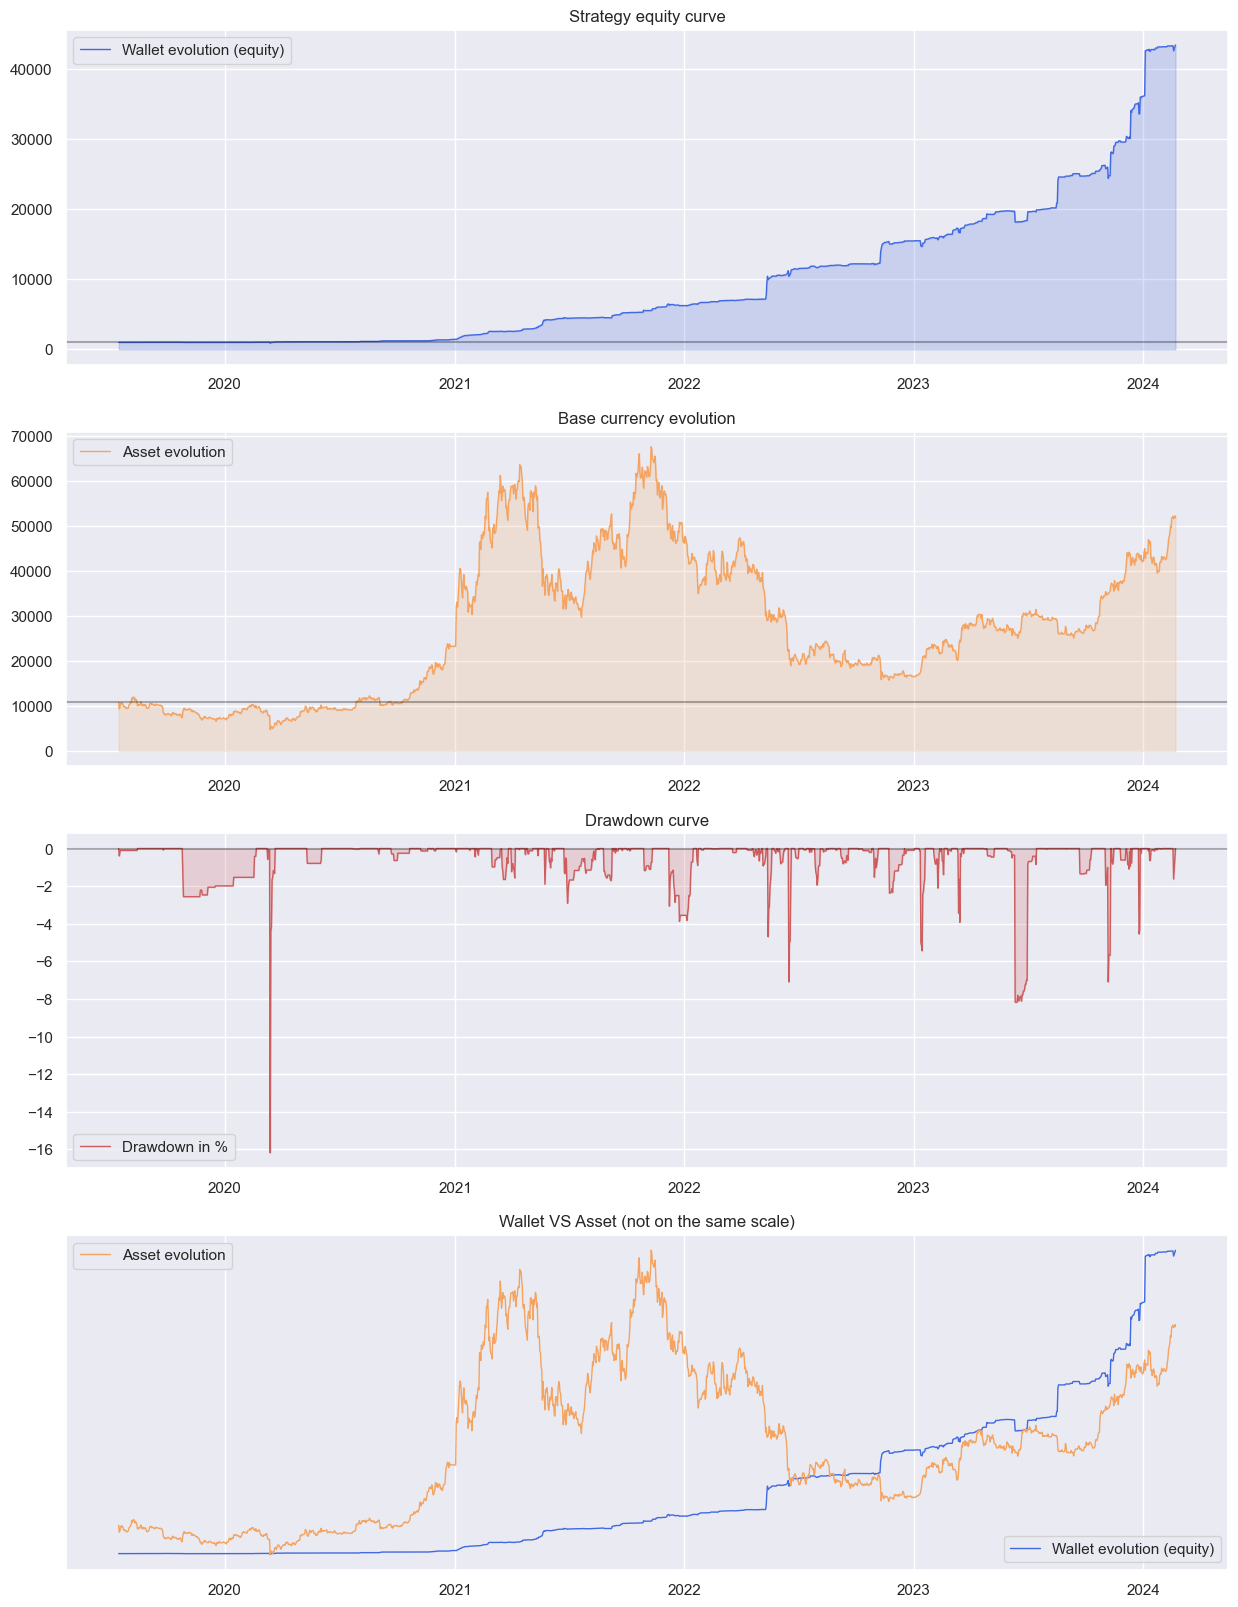

In [45]:
plot_equity_vs_asset(df_days=df_days.loc[:])

----- 2019 Cumulative Performances: -0.28% -----


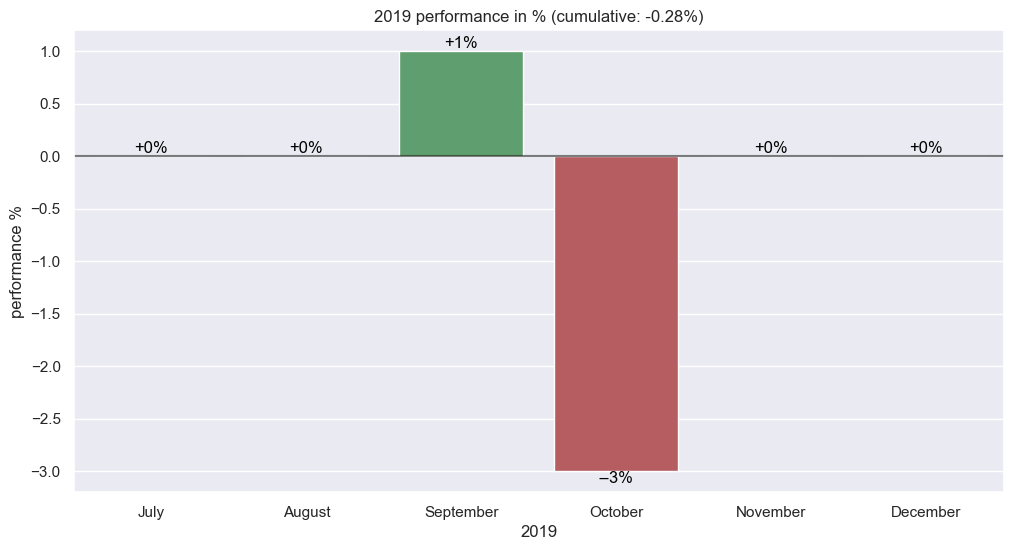

----- 2020 Cumulative Performances: 43.71% -----


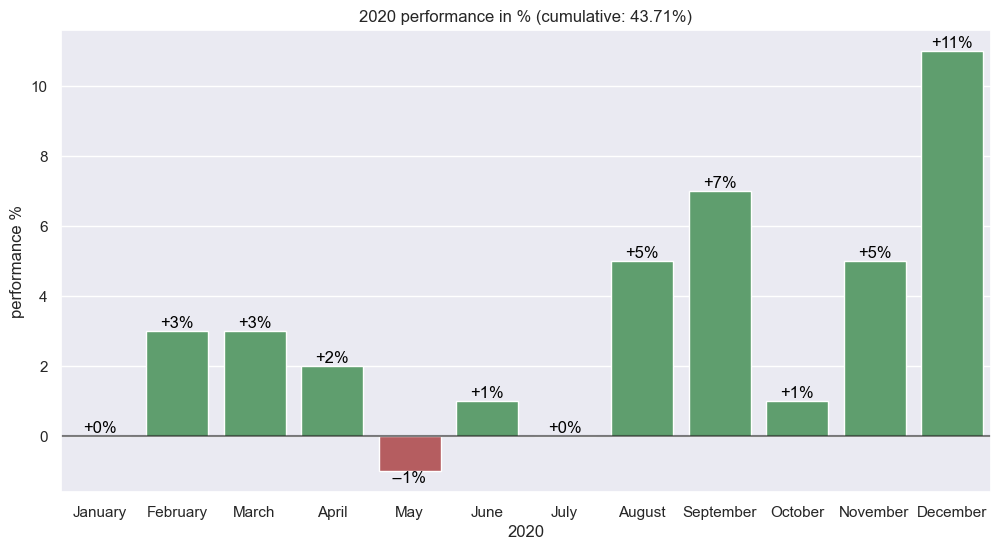

----- 2021 Cumulative Performances: 335.44% -----


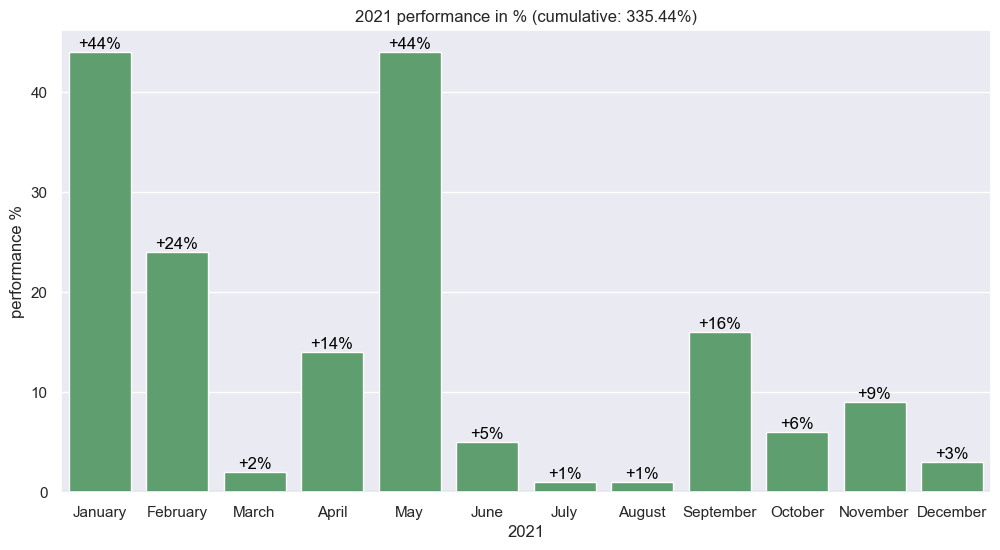

----- 2022 Cumulative Performances: 147.6% -----


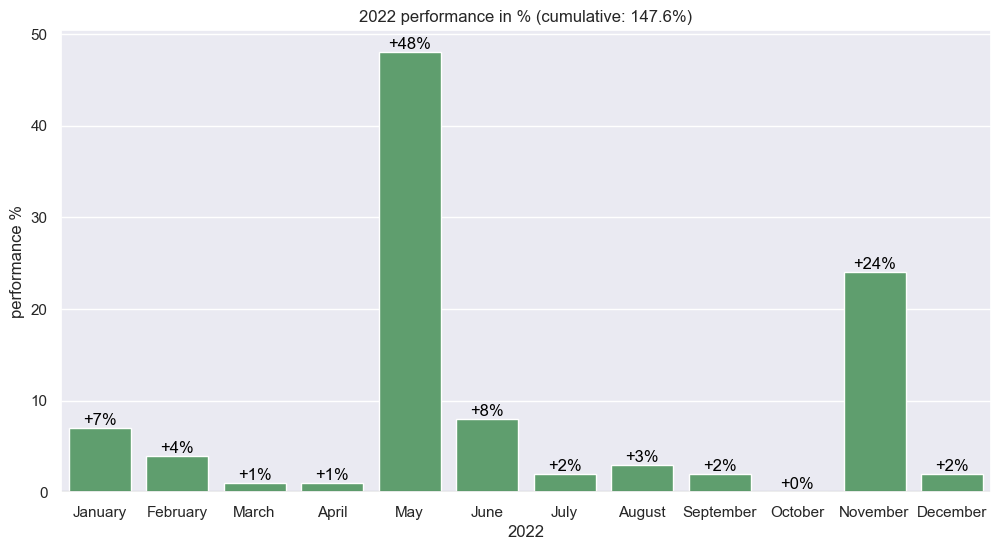

----- 2023 Cumulative Performances: 133.43% -----


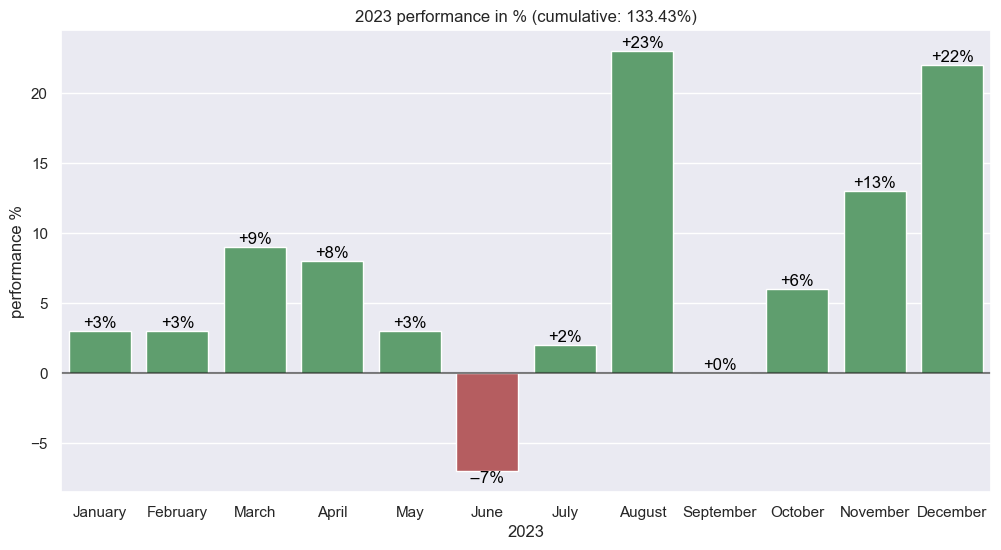

----- 2024 Cumulative Performances: 20.18% -----


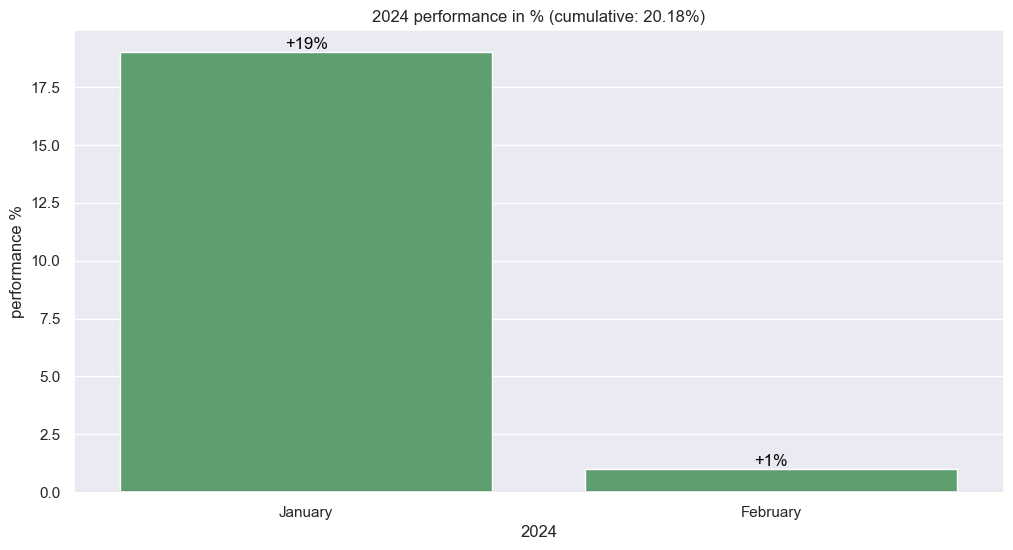

In [46]:
plot_bar_by_month(df_days=df_days)

In [47]:
df_trades.sort_values(by=["trade_result_pct"])

,pair,open_date,close_date,position,open_reason,close_reason,open_price,close_price,open_fee,close_fee,open_trade_size,close_trade_size,wallet,trade_result,trade_result_pct,trade_result_pct_wallet,trades_duration,wallet_ath,drawdown,drawdown_pct
open_date,,,,,,,,,,,,,,,,,,,,
2023-12-24 08:00:00,KSM/USDT:USDT,2023-12-24 08:00:00,2023-12-24 14:00:00,SHORT,Limit Envelop 3,SL,45.447164,60.531100,1.056977,2.118074,5283.828445,3530.123203,33476.041514,-1754.762219,-0.332101,-0.055318,0 days 06:00:00,35232.921807,1756.880293,0.049865
2023-11-05 00:00:00,EGLD/USDT:USDT,2023-11-05 00:00:00,2023-11-05 06:00:00,SHORT,Limit Envelop 4,SL,39.628585,51.726850,1.039241,2.165476,5195.165063,3609.125945,24391.907601,-1587.078359,-0.305491,-0.069594,0 days 06:00:00,26253.659733,1861.752132,0.070914
2021-12-07 17:00:00,XTZ/USDT:USDT,2021-12-07 17:00:00,2021-12-08 00:00:00,SHORT,Limit Envelop 3,Market,4.694471,5.467800,0.194100,0.486280,970.306930,810.466514,6309.550772,-160.034516,-0.164932,-0.026024,0 days 07:00:00,6484.424838,174.874066,0.026968
2022-11-22 12:00:00,CRV/USDT:USDT,2022-11-22 12:00:00,2022-11-22 18:00:00,SHORT,Limit Envelop 4,Market,0.529838,0.611520,0.304942,0.773640,1524.407512,1289.399655,15013.959299,-235.312799,-0.154363,-0.015922,0 days 06:00:00,15392.311646,378.352346,0.024581
2022-06-13 00:00:00,CRV/USDT:USDT,2022-06-13 00:00:00,2022-06-13 12:00:00,LONG,Limit Envelop 3,Market,0.771098,0.662540,0.323731,0.278099,1618.329147,1390.495244,10737.542106,-228.157633,-0.140983,-0.021710,0 days 12:00:00,10965.654108,228.112002,0.020802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-17 21:00:00,ETH/USDT:USDT,2023-08-17 21:00:00,2023-08-17 22:00:00,LONG,Limit Envelop 3,Market,1549.039446,1709.448000,1.668112,1.840482,8338.890051,9202.411826,21708.976278,861.853663,0.103354,0.038184,0 days 01:00:00,21708.976278,0.000000,0.000000
2021-05-21 20:00:00,ADA/USDT:USDT,2021-05-21 20:00:00,2021-05-21 22:00:00,LONG,Limit Envelop 3,Market,1.371876,1.514996,0.158817,0.175351,793.927563,876.753465,4055.881381,82.667084,0.104124,0.019975,0 days 02:00:00,4055.881381,0.000000,0.000000
2020-03-13 03:00:00,ETH/USDT:USDT,2020-03-13 03:00:00,2020-03-13 04:00:00,SHORT,Limit Envelop 3,Market,123.333751,109.424000,0.072335,0.241431,361.603191,402.385297,944.681267,40.709772,0.112581,0.041313,0 days 01:00:00,1028.441866,83.760599,0.081444


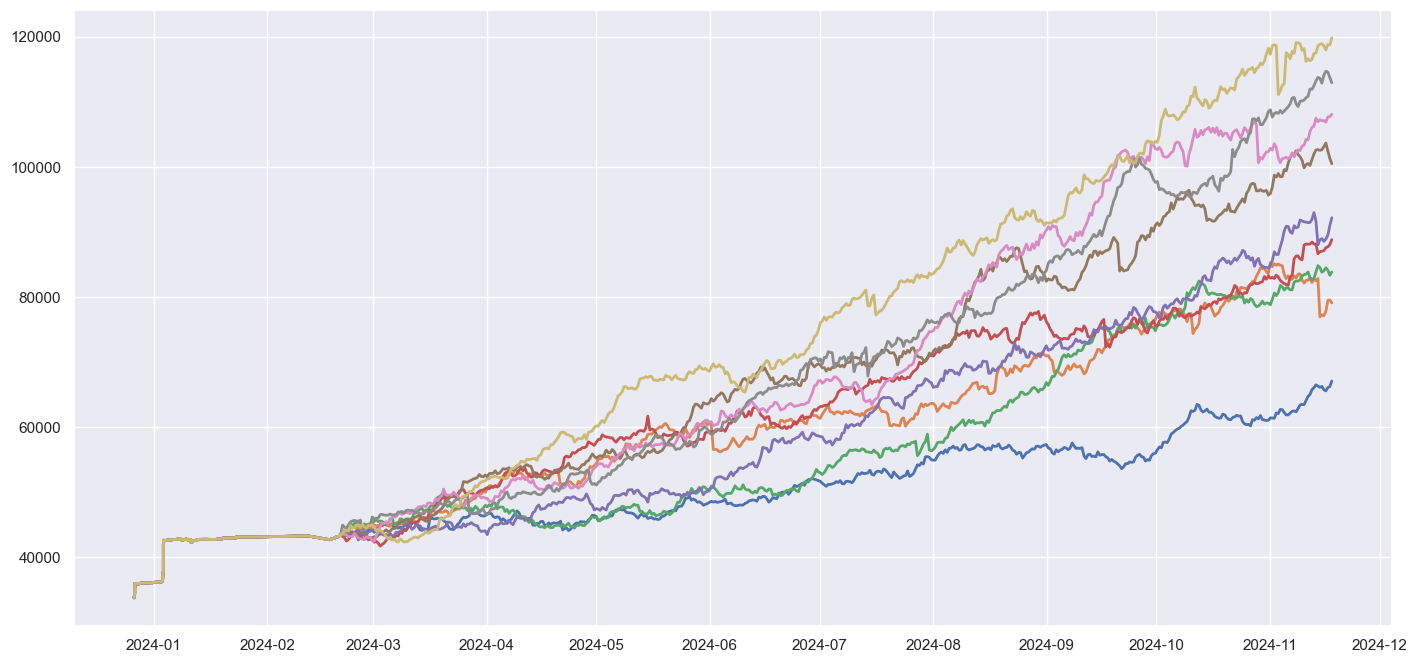

In [48]:
plot_futur_simulations(
    df_trades=df_trades,
    trades_multiplier=3,
    trades_to_forecast=500,
    number_of_simulations=100,
    true_trades_to_show=100,
    # show_all_simulations=True,
)

In [49]:
from lightweight_charts import Chart
from lightweight_charts import JupyterChart
pair = "AVAX/USDT:USDT"
dt = df_list[pair].copy().loc["2023-11"]
dt_trades = df_trades.copy().loc["2023-11"]
dt_trades = dt_trades.loc[dt_trades["pair"] == pair]
chart = JupyterChart(width=900, height=400)

dt["time"] = dt.index
chart.set(dt)

lines = ["ma_base"]
for i in range(1, len(params[pair]["envelopes"]) + 1):
    lines.append(f"ma_low_{i}")
    lines.append(f"ma_high_{i}")
for line in lines:
    line_object = chart.create_line(line, width=1)
    line_data = pd.DataFrame({"time": dt.index, line: dt[line]})
    line_object.set(line_data)

def place_buy_order(key):
    print(f'Buy {key} shares.')

for trades in dt_trades.iterrows():
    if trades[1]['position'] == "LONG":
        chart.marker(time=trades[1]['open_date'], position="below", shape="arrow_up", color="green", text="Long")
        chart.marker(time=trades[1]['close_date'], position="above", shape="arrow_down", color="white", text=trades[1]["close_reason"])
    elif trades[1]['position'] == "SHORT":
        chart.marker(time=trades[1]['open_date'], position="above", shape="arrow_down", color="red", text="Short")
        chart.marker(time=trades[1]['close_date'], position="below", shape="arrow_up", color="white", text=trades[1]["close_reason"])

# chart.show(block=True)
chart.load()

